# Testing different algorithms
**Exploring different reconstruction algorithms and finding the one best suited for a particular dataset.**

Every experimental dataset is different and sometimes the common choice of DM or ePIE as an engine for the initial reconstruction might not be the best solution. Ptychography is a very popular technique with lots of new algorithms and modifications to existing algorithms published every year. It might be worth exploring some of these new methods when working with a challenging experimental data set. In this example, we are looking at an algorithm called the [semi-implicit relaxed Douglas-Rachford](https://doi.org/10.1364/OE.27.031246) (SDR) algorithm, which is essentialy a variation of ePIE with a DM-like Fourier update. 

## The data

The data used for this example is from a butterfly scale and has been collected at the I13 instrument at the Diamond Light Source. The raw data has been taken with an array of MediPix3 detectors and their intensities stored in an HDF5 file ```"dls_i13_butterfly/raw/excalibur_306517_vds.h5"``` with the following entry

```bash
	* data                           shape = (1260, 1793, 2069)
```

This was a tomographic scan and the scan positions were recorded in a coordinate system that is different from the plane in which the sample was scannend, therefore the positions hat to be converted and were saved in a separate file ```"dls_i13_butterfly/processing/pos/306517.h5"``` with the relevant entries for the slow/fast axis of the scanning stage

```bash
	* slow                           shape = (1260,)
	* fast                           shape = (1260,)
```

There are two main reasons that make this data set a little bit challenging. First, the detector has some missing regions which need to be considered in the reconstruction by providing a binary mask, available ```"dls_i13_butterfly/processing/masks/excalibur_512x512.h5"``` 

![](./_assets/i13_mask.png)

and second, the chosen step size of the scan together with the fact that it follows a "snake" trajectory on a rectangular grid makes it prone to grid artefacts. 

## Loading the data

We can again used the ```"Hdf5LoaderFast"``` for improved file reading performance

```python
p.scans.scan_00.data = u.Param()
p.scans.scan_00.data.name = 'Hdf5LoaderFast'
p.scans.scan_00.data.orientation = 0
```

load the intensities

```python
p.scans.scan_00.data.intensities = u.Param()
p.scans.scan_00.data.intensities.file = path_to_data
p.scans.scan_00.data.intensities.key = "data"
```

and scan positions

```python
p.scans.scan_00.data.positions = u.Param()
p.scans.scan_00.data.positions.file = path_to_pos
p.scans.scan_00.data.positions.slow_key = "slow"
p.scans.scan_00.data.positions.slow_multiplier = 1e-6
p.scans.scan_00.data.positions.fast_key = "fast"
p.scans.scan_00.data.positions.fast_multiplier = 1e-6
```

as well as the mask

```python
p.scans.scan_00.data.mask = u.Param()
p.scans.scan_00.data.mask.file = path_to_mask
p.scans.scan_00.data.mask.key = "data"
```

and finally provide information (energy, distance, pixel size)

```python

p.scans.scan_00.data.distance = 14.65
p.scans.scan_00.data.energy = 9.7
p.scans.scan_00.data.psize = 55e-6
p.scans.scan_00.data.auto_center = False
p.scans.scan_00.data.center = (903.5, 1018.)
p.scans.scan_00.data.shape = (512,512)
```

and tell the loader to crop a region of shape ```(512,512)``` around the center located at ```(903.5, 1018.)```.



## Initial probe

For the initial probe, we can load an already existing probe from a previous reconstruction that was performed during the same experiment with more favourable scan conditions, saved in ```"dls_i13_butterfly/processing/ptypy/testing/303079_ML_pycuda_1500.ptyr"``` and looking like this

![](./_assets/i13_initial_probe.png)

## Reconstruction engine

As mentioned above, it was found that the SDR algorithm is quite well-suited for this data set, minimising the artefacts that can arise from missing data in the detector and the raster grid pathology. For the engine parameters, we can follow the suggestions from the [SDR paper](https://doi.org/10.1364/OE.27.031246) which suggests $\sigma=0.5$ and $\tau=0.1$

```python
p.engines = u.Param()
p.engines.engine_dr = u.Param()
p.engines.engine_dr.name = "SDR_cupy"
p.engines.engine_dr.numiter = 100
p.engines.engine_dr.numiter_contiguous = 1
p.engines.engine_dr.sigma = 0.5
p.engines.engine_dr.tau = 0.1
p.engines.engine_dr.compute_log_likelihood = True
p.engines.engine_dr.compute_exit_error = False
```

and after $100$ iterations we get a nice-looking image of a butterfly scale

![](./_assets/i13_recons_sdr.png)

<div class="alert alert-warning" markdown="1">
    <strong>Challenge</strong><br>Explore different algorithms such as ePIE, DM, ML, etc. for example by using parameters from other examples and compare against this SDR reconstruction. Which algorithm do you believe worked best for this particular dataset?
</div>

---

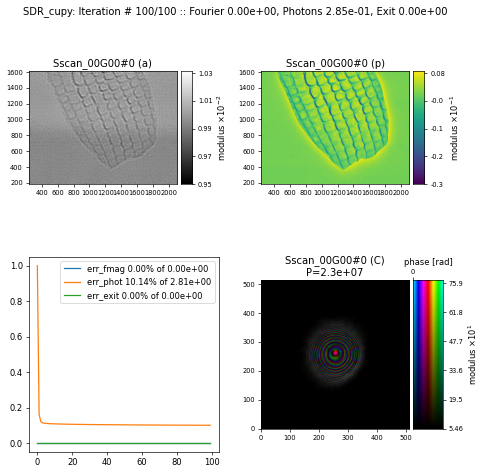


==== This reconstruction relied on the following work ==========================
The Ptypy framework:
    Enders B. and Thibault P., "A computational framework for ptychographic reconstructions" Proc. Royal Soc. A 472 (2016) 20160640, doi: 10.1098/rspa.2016.0640.
The semi-implicit relaxed Douglas-Rachford reconstruction algorithm:
    Pham et al., "Semi-implicit relaxed Douglas-Rachford algorithm (sDR) for ptychography" Opt. Express 27 (2019) 31246, doi: 10.1364/OE.27.031246.


<Figure size 640x480 with 0 Axes>

In [1]:
import ptypy, os
import ptypy.utils as u

# This will import the HDF5Loader class
ptypy.load_ptyscan_module("hdf5_loader")

# This will import the GPU engines
ptypy.load_gpu_engines("cupy")  

# Root directory of tutorial data
tutorial_data_home = "../../data/"

# Path to HDF5 file with raw data and positions
dataset = "dls_i13_butterfly/raw/excalibur_306517_vds.h5"
positions = "dls_i13_butterfly/processing/pos/306517.h5"

# Path to a previous reconstruction
init_probe = "dls_i13_butterfly/processing/ptypy/testing/303079_ML_pycuda_1500.ptyr"

# Path to HDF5 file with mask
mask = "dls_i13_butterfly/processing/masks/excalibur_512x512.h5"

# Absolute paths to HDF5 files with raw data, positions
# initial probe and mask
path_to_data = os.path.join(tutorial_data_home, dataset)
path_to_pos = os.path.join(tutorial_data_home, positions)
path_to_probe = os.path.join(tutorial_data_home, init_probe)
path_to_mask = os.path.join(tutorial_data_home, mask)

# Create parameter tree
p = u.Param()

# Set verbose level to info
p.verbose_level = "interactive"

# Scan label
p.run = "dls_i13_butterfly"

# Data loading and processing should 
# happen in chunks of this size
p.frames_per_block = 200

# Set io settings (no files saved)
p.io = u.Param()
p.io.rfile = None
p.io.autosave = u.Param(active=False)
p.io.interaction = u.Param(active=False)

p.io.autoplot = u.Param()
p.io.autoplot.active = True
p.io.autoplot.threaded = False
p.io.autoplot.layout = "jupyter"
p.io.autoplot.interval = 10

# Define the scan model
p.scans = u.Param()
p.scans.scan_00 = u.Param()
p.scans.scan_00.name = 'BlockFull'

# Initial illumination (based on previous reconstruction)
p.scans.scan_00.illumination = u.Param()
p.scans.scan_00.illumination.model = "recon"
p.scans.scan_00.illumination.recon = u.Param()
p.scans.scan_00.illumination.recon.rfile = path_to_probe
p.scans.scan_00.illumination.photons = None
p.scans.scan_00.illumination.aperture = u.Param()
p.scans.scan_00.illumination.aperture.form = None
p.scans.scan_00.illumination.diversity = u.Param()
p.scans.scan_00.illumination.diversity.power = 0.1
p.scans.scan_00.illumination.diversity.noise = [0.5,1.0]

# Initial object
p.scans.scan_00.sample = u.Param()
p.scans.scan_00.sample.model = None
p.scans.scan_00.sample.diversity = None
p.scans.scan_00.sample.process = None

# Coherence parameters (modes)
p.scans.scan_00.coherence = u.Param()
p.scans.scan_00.coherence.num_probe_modes = 1
p.scans.scan_00.coherence.num_object_modes = 1

# Data loader
p.scans.scan_00.data = u.Param()
p.scans.scan_00.data.name = 'Hdf5LoaderFast'
p.scans.scan_00.data.orientation = 0

p.scans.scan_00.data.intensities = u.Param()
p.scans.scan_00.data.intensities.file = path_to_data
p.scans.scan_00.data.intensities.key = "data"

p.scans.scan_00.data.positions = u.Param()
p.scans.scan_00.data.positions.file = path_to_pos
p.scans.scan_00.data.positions.slow_key = "slow"
p.scans.scan_00.data.positions.slow_multiplier = 1e-6
p.scans.scan_00.data.positions.fast_key = "fast"
p.scans.scan_00.data.positions.fast_multiplier = 1e-6

p.scans.scan_00.data.mask = u.Param()
p.scans.scan_00.data.mask.file = path_to_mask
p.scans.scan_00.data.mask.key = "data"

p.scans.scan_00.data.distance = 14.65
p.scans.scan_00.data.energy = 9.7
p.scans.scan_00.data.psize = 55e-6
p.scans.scan_00.data.auto_center = False
p.scans.scan_00.data.center = (903.5, 1018.)
p.scans.scan_00.data.shape = (512,512)

# Reconstruct using GPU-accelerated SDR
p.engines = u.Param()
p.engines.engine_dr = u.Param()
p.engines.engine_dr.name = "SDR_cupy"
p.engines.engine_dr.numiter = 100
p.engines.engine_dr.numiter_contiguous = 1
p.engines.engine_dr.sigma = 0.5
p.engines.engine_dr.tau = 0.1
p.engines.engine_dr.compute_log_likelihood = True
p.engines.engine_dr.compute_exit_error = False

# Run reconstruction
P = ptypy.core.Ptycho(p,level=5)